<a href="https://colab.research.google.com/github/Aryan625/Custom-Build-Object-Detection-Model/blob/main/Custom_Build_Object_Detection_Model_(SSD_ResNet50_V1_FPN_640x640_(RetinaNet50)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation
Installing the Tensorflow 2 Object Detection API

In [1]:
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3129, done.
remote: Counting objects: 100% (3129/3129), done.
remote: Compressing objects: 100% (2452/2452), done.
remote: Total 3129 (delta 834), reused 1503 (delta 633), pack-reused 0
Receiving objects: 100% (3129/3129), 33.33 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (834/834), done.


In [2]:
# install the Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && sed -i 's/>=2.5.1/==2.5.0/' setup.py && python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.9 MB 10.7 MB/s 
     |████████████████████████████████| 352 kB 51.1 MB/s 
     |████████████████████████████████| 1.6 MB 83.2 MB/s 
     |████████████████████████████████| 23.1 MB 71.5 MB/s 
     |████████████████████████████████| 90 kB 13.8 MB/s 
     |████████████████████████████████| 596 kB 72.4 MB/s 
     |████████████████████████████████| 47.7 MB 96.4 MB/s 
     |████████████████████████████████| 1.1 MB 68.6 MB/s 
     |████████████████████████████████| 213 kB 86.5 MB/s 
     |████████████████████████████████| 43 kB

## Imports

Let's now import the packages that will be used in this project.

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

#### Import Object Detection API packages  
Import the necessary modules from the object_detection package

In [4]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

# import module for utilities in Colab
from object_detection.utils import colab_utils

Define a couple of utility functions for loading images and plotting detections.

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

## Download the dataset

Get 10 images of cars that will be used for training.

Download the images into a local `training/` directory by running the cell below.

In [6]:
!mkdir training

In [7]:
%cd /content/training
!wget -O training-car1.jpg https://live.staticflickr.com/8/7338/9978388665_a93d901733_z.jpg
!wget -O training-car2.jpg https://live.staticflickr.com/3/2744/5767538853_54c31b1f57_z.jpg
!wget -O training-car3.jpg https://live.staticflickr.com/3/2702/4475046339_4037ff0618_z.jpg
!wget -O training-car4.jpg https://live.staticflickr.com/8/7289/8741017294_1804e79409_z.jpg
!wget -O training-car5.jpg https://live.staticflickr.com/4/3853/14350411899_fbd590f057_z.jpg
!wget -O training-car6.jpg https://live.staticflickr.com/9/8193/8379986109_e199cd6df7_z.jpg
!wget -O training-car7.jpg https://live.staticflickr.com/3/2266/2120763225_3d3a420f34_z.jpg
!wget -O training-car8.jpg https://live.staticflickr.com/6/5207/5288376283_69861993fd_z.jpg
!wget -O training-car9.jpg https://live.staticflickr.com/1/78/203463972_de03d5a42c_z.jpg
!wget -O training-car10.jpg https://live.staticflickr.com/4/3708/12593832415_50c4895eed_z.jpg

/content/training
--2022-01-23 14:20:03--  https://live.staticflickr.com/8/7338/9978388665_a93d901733_z.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:c400:0:5a51:64c9:c681, 2600:9000:20be:7000:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘training-car1.jpg’

training-car1.jpg       [ <=>                ] 121.28K  --.-KB/s    in 0.02s   

2022-01-23 14:20:04 (7.09 MB/s) - ‘training-car1.jpg’ saved [124191]

--2022-01-23 14:20:04--  https://live.staticflickr.com/3/2744/5767538853_54c31b1f57_z.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:c400:0:5a51:64c9:c681, 2600:9000:20be:7000:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

Let's visualize the training images

/content/training/training-car1.jpg
/content/training/training-car2.jpg
/content/training/training-car3.jpg
/content/training/training-car4.jpg
/content/training/training-car5.jpg
/content/training/training-car6.jpg
/content/training/training-car7.jpg
/content/training/training-car8.jpg
/content/training/training-car9.jpg
/content/training/training-car10.jpg


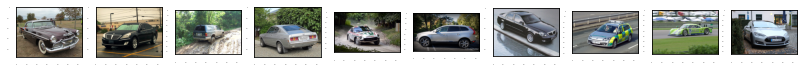

In [8]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = '/content/training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 11):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir, 'training-car' + str(i) + '.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

#configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 10, idx+1)
    plt.imshow(train_image_np)

plt.show()

## Prepare the data for training

In [9]:
# Define the list of ground truth boxes
gt_boxes = []

In [10]:
# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [11]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.24272222 0.0390625  0.94272222 0.9515625 ]]
[[0.30938889 0.0796875  0.84605555 0.925     ]]
[[0.33438889 0.2578125  0.77938889 0.7390625 ]]
[[0.33605555 0.071875   0.93438889 0.9625    ]]
[[0.34938889 0.184375   0.83605555 0.6890625 ]]
[[0.30438889 0.034375   0.94105555 0.9453125 ]]
[[0.06938889 0.0546875  0.73605555 0.96875   ]]
[[0.21272222 0.2265625  0.89605555 0.91875   ]]
[[0.30938889 0.221875   0.61605555 0.9140625 ]]
[[0.23772222 0.175      0.85272222 0.88125   ]]


#### Define the category index dictionary

In [12]:
car_class_id = 1

# define a dictionary describing the car class
category_index = {car_class_id :
                  {'id' : car_class_id,
                   'name' : 'car'}
                 }

# Specify the number of classes that the model will predict
num_classes = 1

In [13]:
print(category_index[car_class_id])

{'id': 1, 'name': 'car'}


#### Data preprocessing
Some data preprocessing is done so it is formatted properly before it is fed to the model:

In [14]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


Visualize the cars with their ground truth bounding boxes

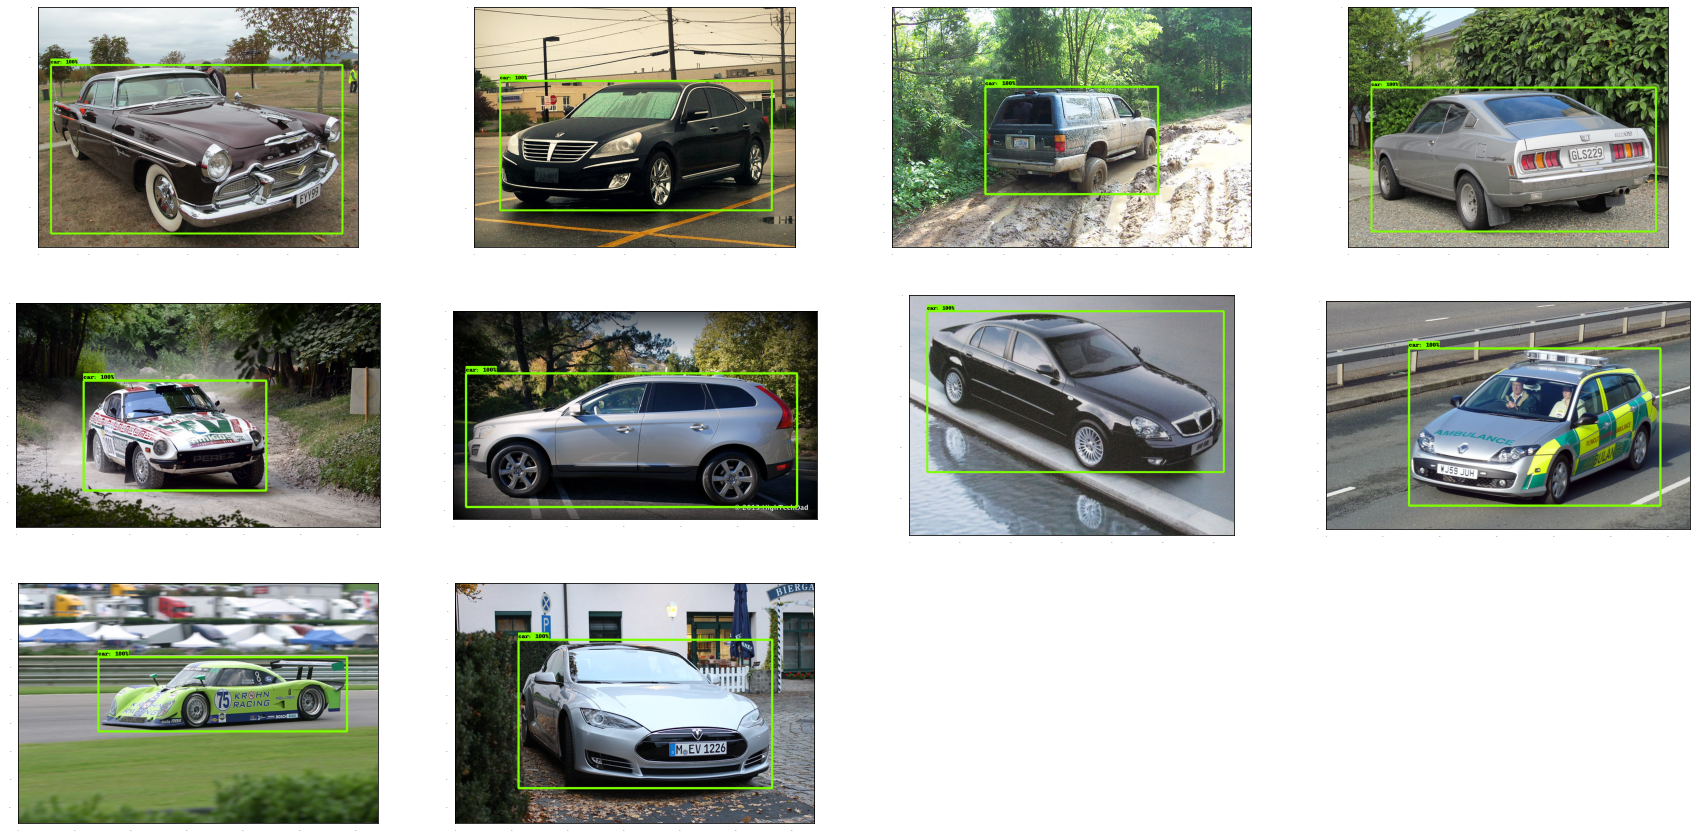

In [15]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(10):
    plt.subplot(3, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

## Download the checkpoint containing the pre-trained weights
  - Download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
  - Untar (decompress) the tar file
  - Move the decompressed checkpoint to `models/research/object_detection/test_data/`

In [16]:
%cd /content/
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint /content/models/research/object_detection/test_data

/content
--2022-01-23 14:25:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   177MB/s    in 1.3s    

2022-01-23 14:25:38 (177 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



## Locate and read from the configuration file and modify the model configuration

Locate and read from the configuration file

In [17]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 152 v1 1024x1024
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

Get the model configuration

In [18]:
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

# see what model_config looks like before modification
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

Modify model_config

In [19]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after it has been customized!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

## Build the custom model

In [20]:
detection_model = model_builder.build(model_config=model_config, is_training=True)
print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


## Restore weights from the checkpoint

Now, weights are selectively restored from the checkpoint.
- The end goal is to create a custom model which reuses parts of, but not all of the layers of RetinaNet (currently stored in the variable `detection_model`.)
  - The parts of RetinaNet that is to be reused are:
    - Feature extraction layers
    - Bounding box regression prediction layer
  - The part of RetinaNet that is not to be reused is the classification prediction layer (since it will be defined and trained by its own classification layer specific to cars).
  - For the parts of RetinaNet that is to be reused, weights are also to be restored from the checkpoint that is later selected.

### Define checkpoints for desired layers
Isolate the layers of `detection_model` that is to be reused so that weights can be restored to just those layers.
- First, define checkpoints for the box predictor
- Next, define checkpoints for the model, which will point to this box predictor checkpoint as well as the feature extraction layers.

#### Define Checkpoints for the box predictor
Define `box_predictor_checkpoint` to be checkpoint for these two layers of the `detection_model`'s box predictor:
  - The base tower layer (the layers the precede both the class prediction and bounding box prediction layers).
  - The box prediction head (the prediction layer for bounding boxes).
  - The class prediction layer will not be included

In [21]:
#Define Checkpoints for the box predictor
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head = detection_model._box_predictor._box_prediction_head
)

In [22]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_attached_dependencies': None,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f4a5fcc1f10>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f4a5f7f1b10>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_base_tower_layers_for_heads', ref=DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])})),
  TrackableReference(name='_box_prediction_head', ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7f4a5fcc1f10>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_depe

#### Define the temporary model checkpoint
Define `tmp_model_checkpoint` so that it points to these two layers:
- The feature extractor of the detection model.
- The temporary box predictor checkpoint that is just defined above.

In [23]:
#Define the temporary model checkpoint
tmp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor = detection_model._feature_extractor,
    _box_predictor = tmp_box_predictor_checkpoint
)

In [24]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_attached_dependencies': None,
 '_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f4a5f7f1e50>,
 '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7f4a5ff57a50>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f4a5fc98050>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_box_predictor', ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7f4a5f7f1e50>),
  TrackableReference(name='_feature_extractor', ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7f4a5ff57a50>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'_box_predictor': <tensor

#### Restore the checkpoint
First, find and set the `checkpoint_path`

Next, define one last checkpoint using `tf.train.Checkpoint()`.
- For the single keyword argument, 
  - Set the key as `model=` 
  - Set the value to your temporary model checkpoint that is just defined above.

Finally, call this checkpoint's `.restore()` function, passing in the path to the checkpoint.

In [25]:
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)

#### Run a dummy image to generate the model variables
We will pass in a dummy image through the forward pass to create the trainable variables.

In [26]:
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

print('Weights restored!')

Weights restored!


## Eager mode custom training loop

With the data and model now setup, we can now proceed to configure the training loop.

#### Set training hyperparameters

In [27]:
tf.keras.backend.set_learning_phase(True)

# set the batch_size
batch_size = 4

# set the number of batches
num_batches = 200

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Choose the layers to fine-tune

To make use of transfer learning and pre-trained weights, only certain parts of the detection model wiil be trained, namely, the last prediction layers.

In [28]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

#### Select the prediction layer variables that is to be fine tuned

Based on inspecting the `detection_model.trainable_variables`, select the prediction layer variables that is to be fine tuned:
- The bounding box head variables (which predict bounding box coordinates)
- The class head variables (which predict the class/category)

In [29]:
# define a list that contains the layers that you wish to fine tune
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for v in detection_model.trainable_variables:
  if any([v.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(v)

#### Define the training step
The function below is to set up one training step.
- Preprocess the images
- Make a prediction
- Calculate the loss
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
- Calculate gradients with respect to the variables that is selected to train.
- Optimize the model's variables

In [30]:
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:

        # Preprocess the images
        preprocessed_image_tensor = tf.concat(
          [model.preprocess(image_tensor)[0]
           for image_tensor in image_list], axis=0)
        true_shape_tensor = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)
        
            
        model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)    
        
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
    return total_loss

#### Run the training loop
Run the training loop using the training step function that is just defined above.

In [31]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 200, loss=1.248068
batch 10 of 200, loss=0.24742217
batch 20 of 200, loss=0.07039517
batch 30 of 200, loss=0.031869344
batch 40 of 200, loss=0.017032562
batch 50 of 200, loss=0.01488149
batch 60 of 200, loss=0.00825965
batch 70 of 200, loss=0.012304437
batch 80 of 200, loss=0.009351029
batch 90 of 200, loss=0.006860826
batch 100 of 200, loss=0.008741518
batch 110 of 200, loss=0.0073445956
batch 120 of 200, loss=0.004279048
batch 130 of 200, loss=0.004967978
batch 140 of 200, loss=0.004008549
batch 150 of 200, loss=0.0047043725
batch 160 of 200, loss=0.0035673173
batch 170 of 200, loss=0.00520305
batch 180 of 200, loss=0.004114085
batch 190 of 200, loss=0.0051191547
Done fine-tuning!


## Load test images and run inference with new model.

#### Download two different video to extract still frames as test images

In [32]:
# Drone shot of a car
! gdown --id 1fFDxvhp9kQYvcrYylWPp8YRTADnLtqCc
# Video of Cars on Highway
! gdown --id 1C1r0HIiKroMbOXUrj-sKXOsFBw-Fl3me

Downloading...
From: https://drive.google.com/uc?id=1fFDxvhp9kQYvcrYylWPp8YRTADnLtqCc
To: /content/Pexels Videos 1572442.mp4
100% 18.5M/18.5M [00:00<00:00, 59.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C1r0HIiKroMbOXUrj-sKXOsFBw-Fl3me
To: /content/Cars On Highway.mp4
100% 35.7M/35.7M [00:00<00:00, 97.8MB/s]


In [33]:
!pip3 install opencv-python
!mkdir /content/results_1
!mkdir /content/results_2

In [34]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

First we will do inference on Drone shot of a car.

The cell below save frames from the downloaded video in the `directory = content/results_1/`

In [35]:
import cv2
# Drone shot of a car
vidcap = cv2.VideoCapture('Pexels Videos 1572442.mp4')
def getFrame(sec):
    directory='/content/results_1'
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        os.chdir(directory)
        cv2.imwrite("running-car"+ "{0:02}".format(count) +".jpg", image)     # save frame as JPG file
    return hasFrames
    
sec = 2
frameRate = 0.5 #//it will capture image in each 0.5 second
count=0
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
os.chdir('/content')

Load these images into numpy arrays to prepare it for inference.

In [36]:
test_image_dir = '/content/results_1/'
test_images_np = []

len = ! ls /content/results_1 | wc -l
for i in len:
  l1=int(i)

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, l1):
    image_path = os.path.join(test_image_dir, 'running-car' + "{0:02}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

/content/results_1/running-car00.jpg
/content/results_1/running-car01.jpg
/content/results_1/running-car02.jpg
/content/results_1/running-car03.jpg
/content/results_1/running-car04.jpg
/content/results_1/running-car05.jpg
/content/results_1/running-car06.jpg
/content/results_1/running-car07.jpg
/content/results_1/running-car08.jpg
/content/results_1/running-car09.jpg
/content/results_1/running-car10.jpg
/content/results_1/running-car11.jpg
/content/results_1/running-car12.jpg
/content/results_1/running-car13.jpg
/content/results_1/running-car14.jpg
/content/results_1/running-car15.jpg
/content/results_1/running-car16.jpg
/content/results_1/running-car17.jpg
/content/results_1/running-car18.jpg
/content/results_1/running-car19.jpg
/content/results_1/running-car20.jpg


#### Preprocess, predict, and post process an image

Define a function that returns the detection boxes, classes, and scores.

In [37]:
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

Loop through the test images and get the detection scores and bounding boxes to overlay in the original image. Each result is saved in a `results` dictionary 

In [38]:
cnt=0
for i in test_images_np:
    cnt+=1
cnt 

21

In [41]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(cnt):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="/content/results_1/gif_frame_" + ('%02d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

Output of the inference on some still frames to inspect visually.

Frame 0


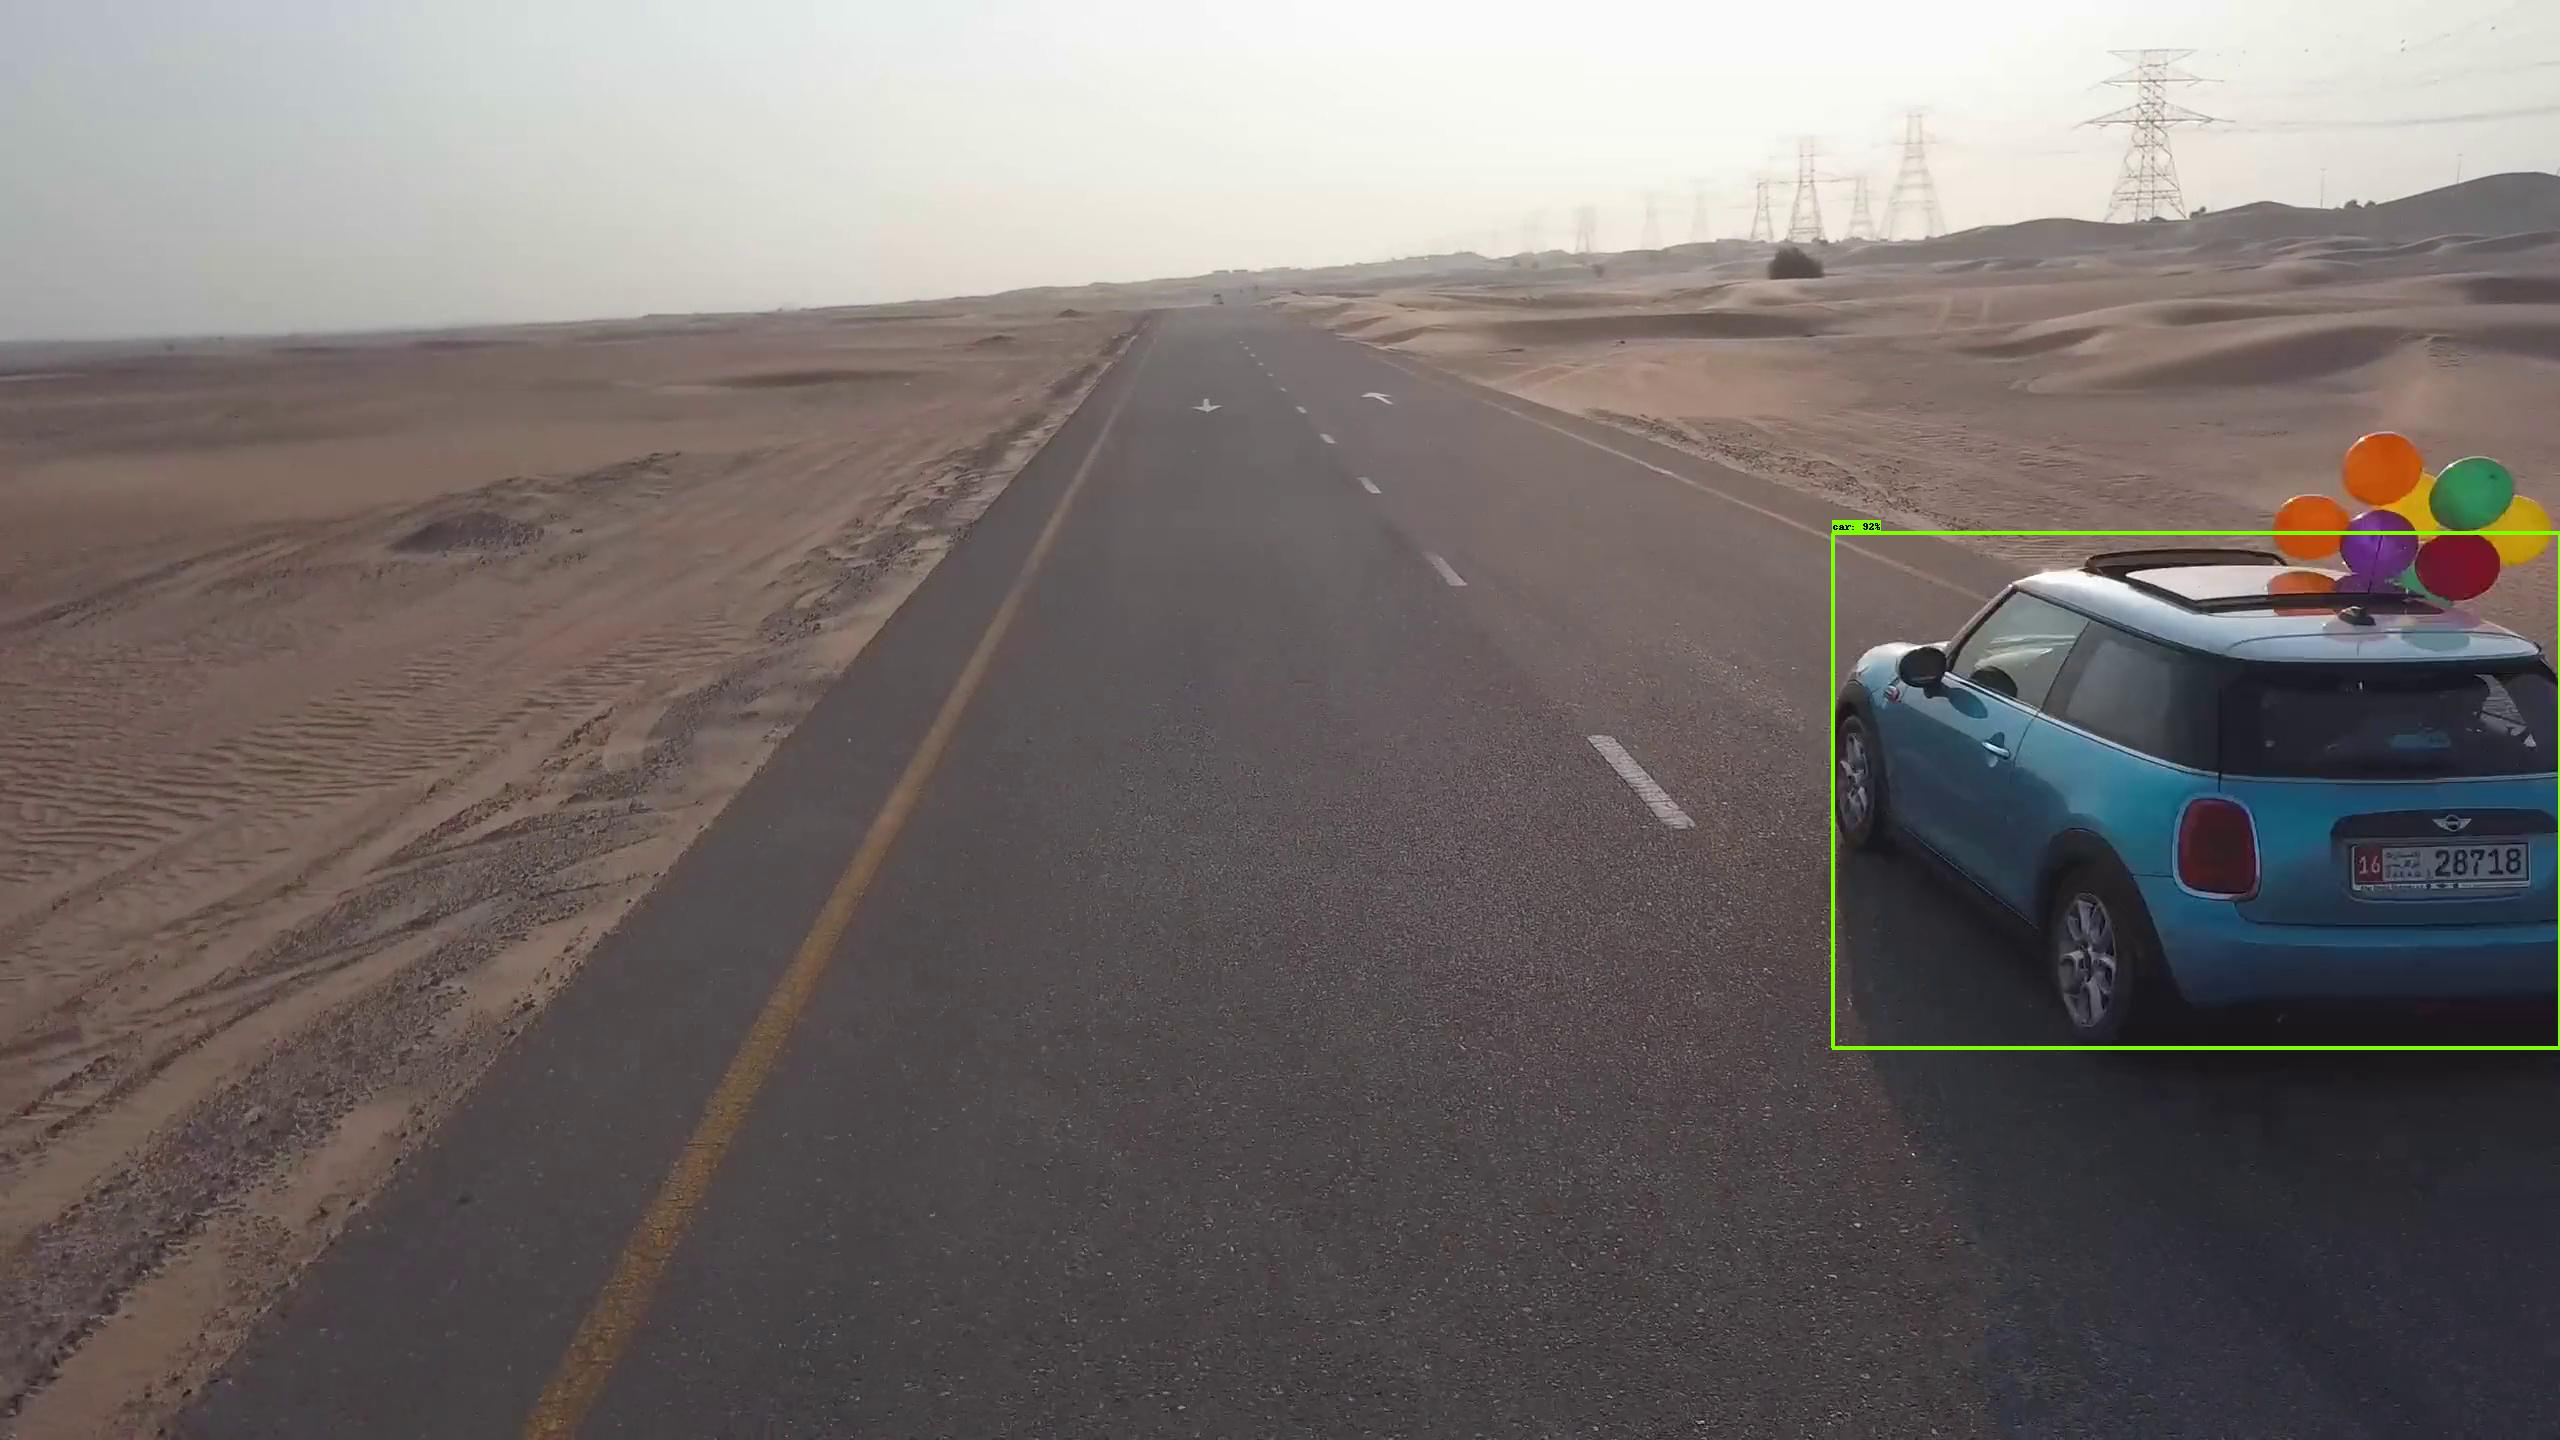


Frame 5


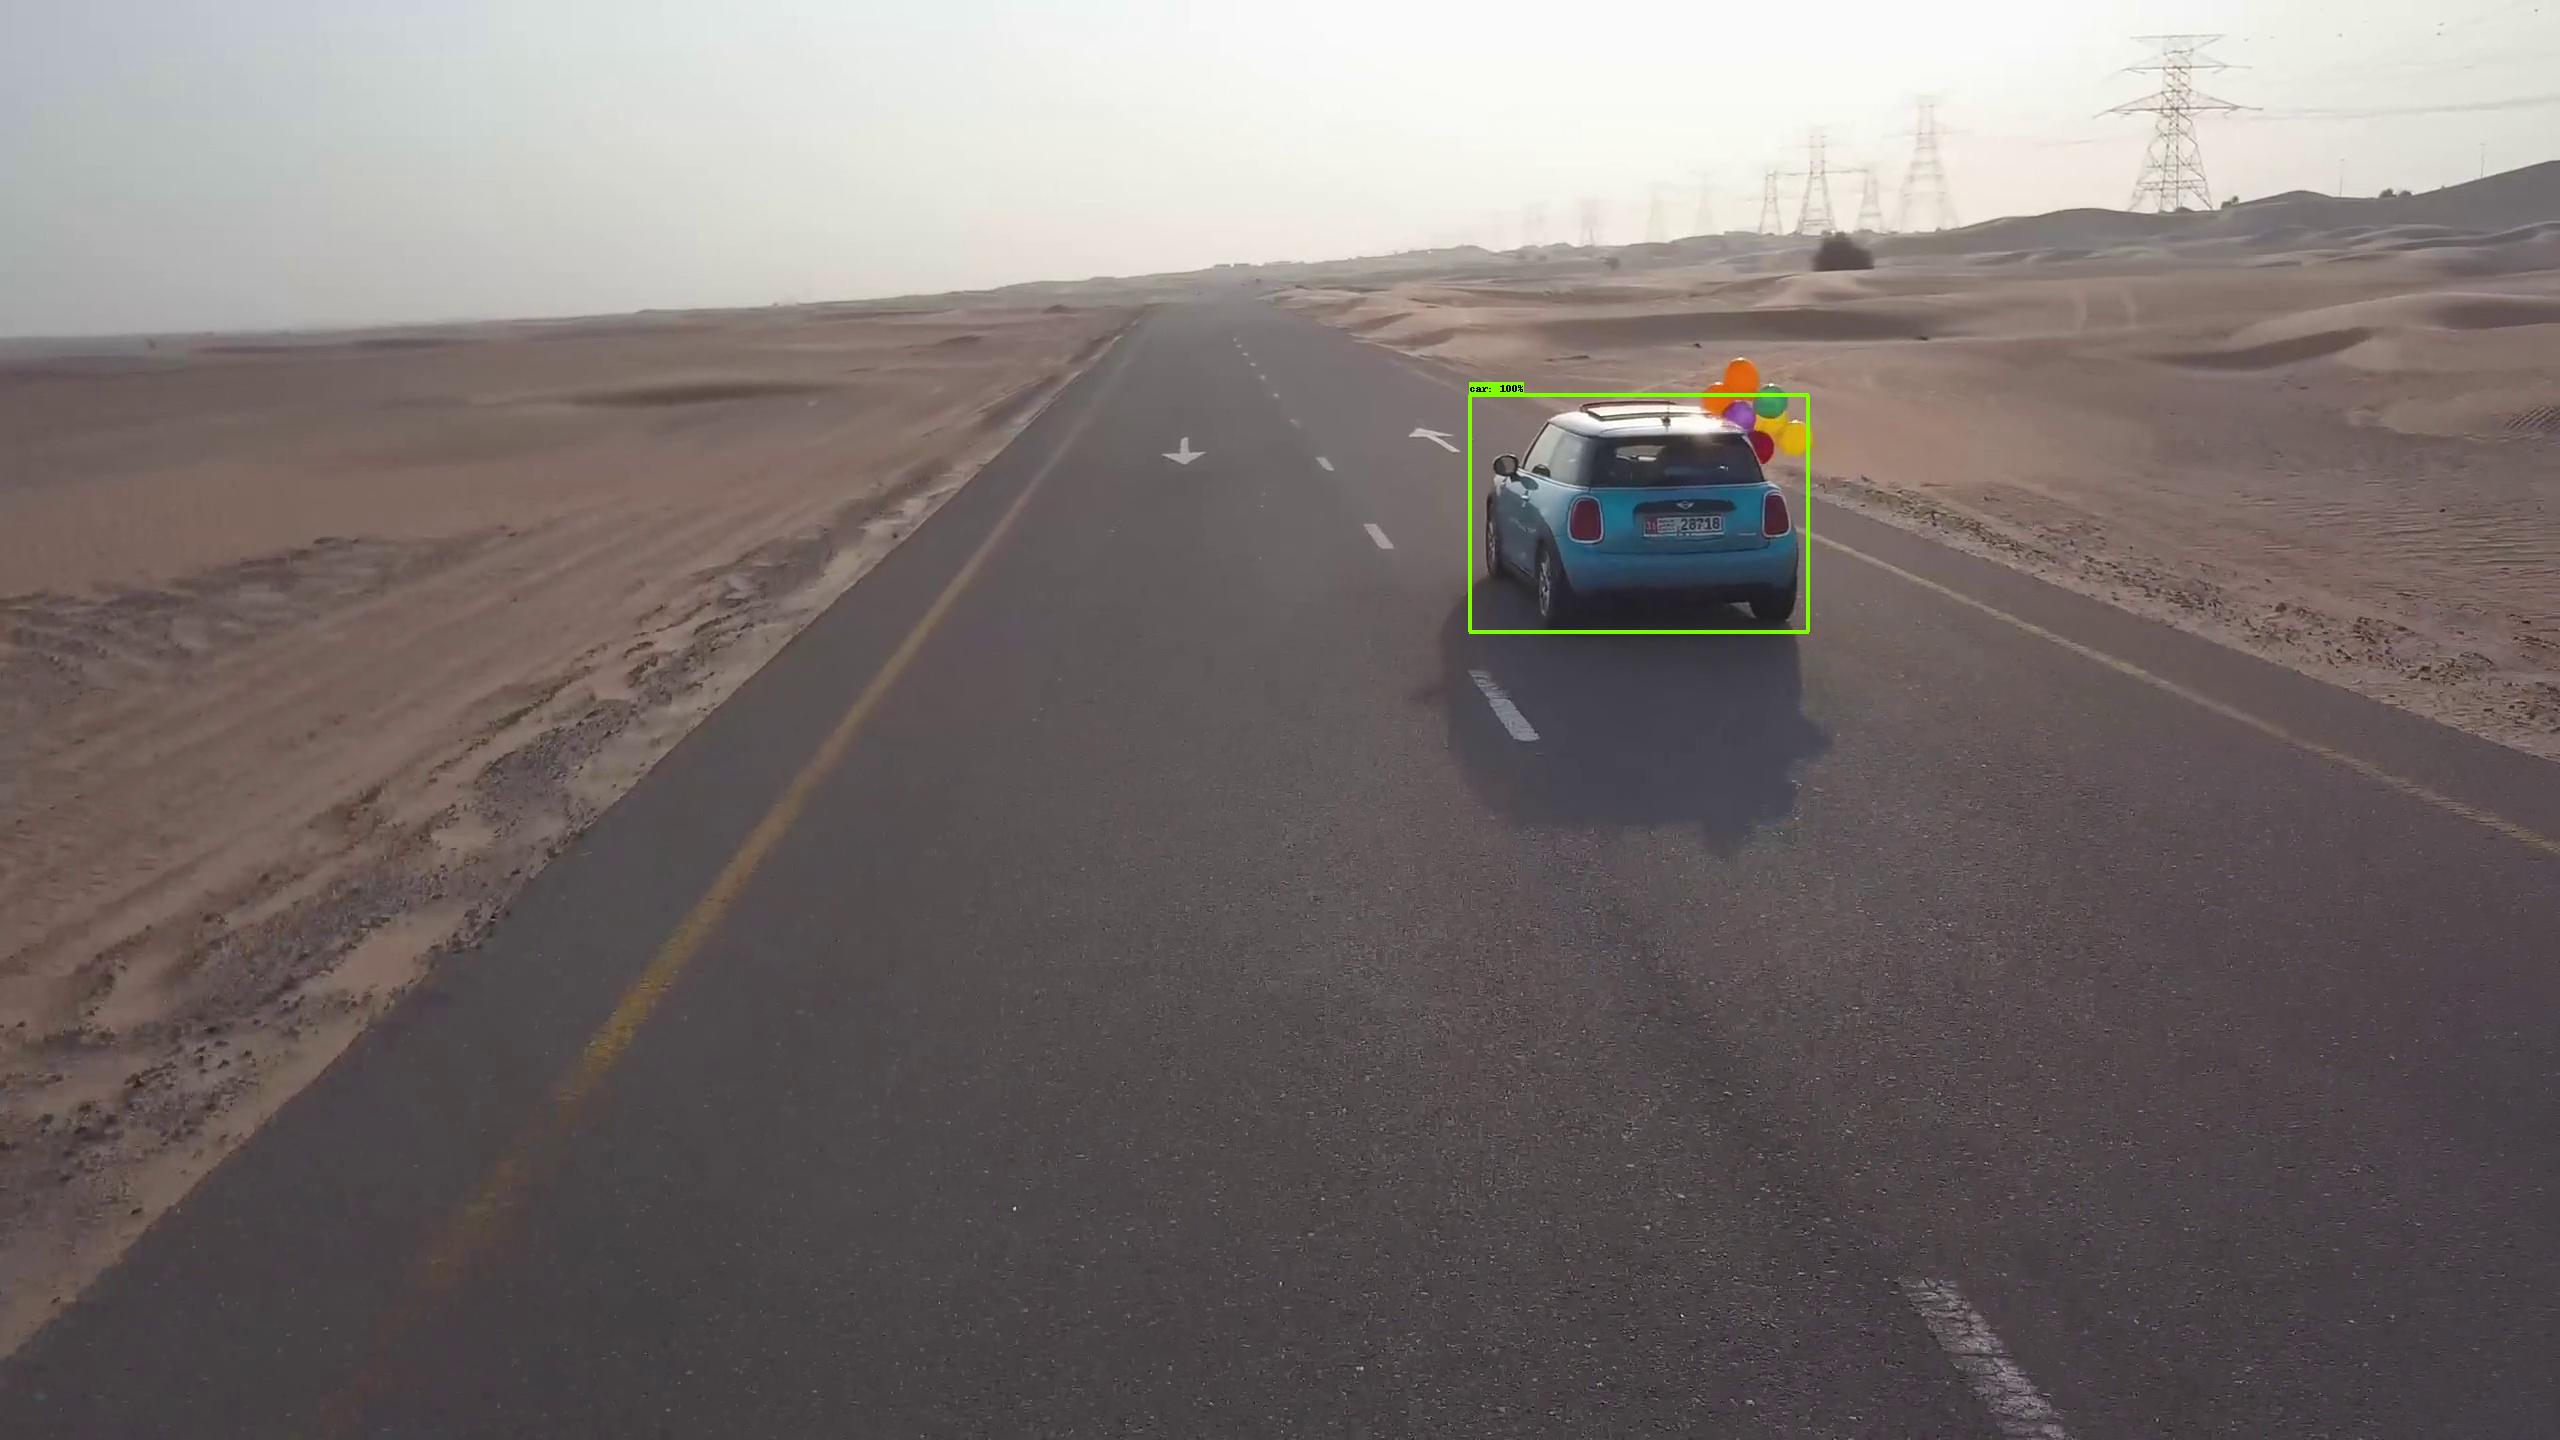


Frame 10


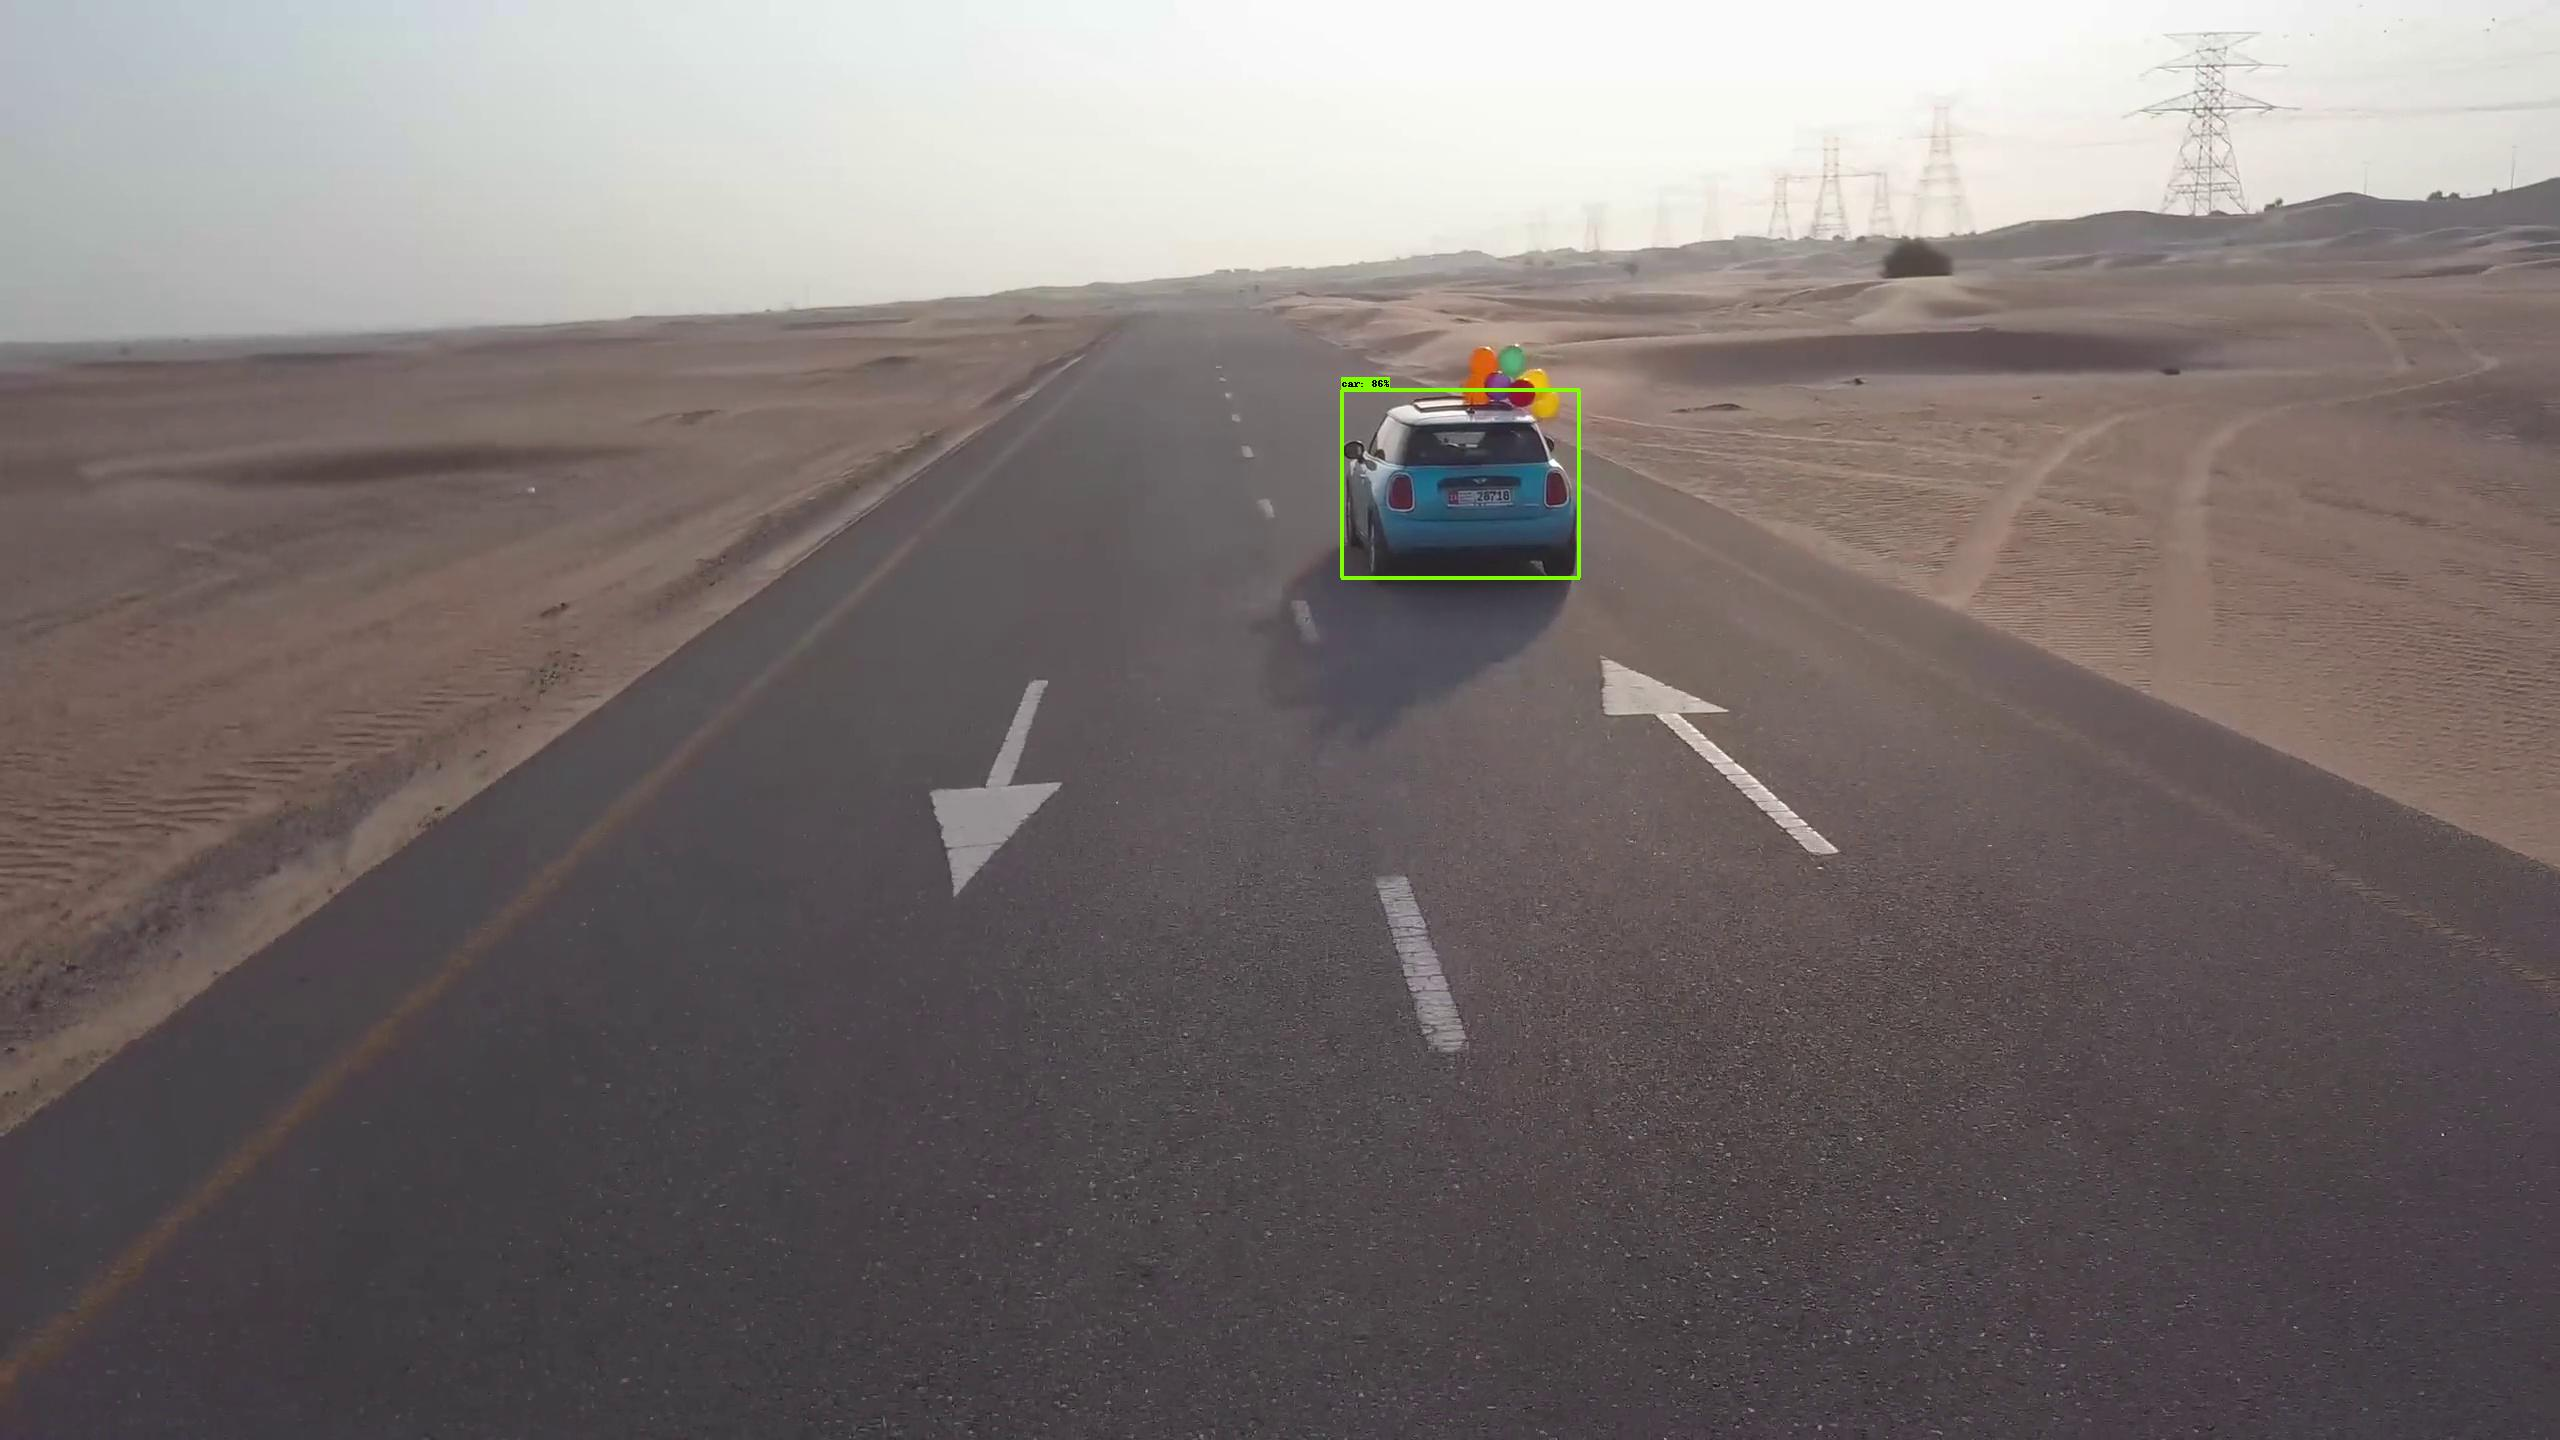

In [44]:
print('Frame 0')
display(IPyImage('/content/results_1/gif_frame_00.jpg'))
print()
print('Frame 5')
display(IPyImage('/content/results_1/gif_frame_05.jpg'))
print()
print('Frame 10')
display(IPyImage('/content/results_1/gif_frame_10.jpg'))

### Create animation of output images after inferencing 

In [43]:
%cd /content/
imageio.plugins.freeimage.download()

anim_file = './car-anim_1.gif'

filenames = glob.glob('/content/results_1/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

/content
Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)3727360/4830080 bytes (77.2%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


## Video of Cars on Highway
Repeat the same process as above to run the inference on second video

In [45]:
# Video of Cars on Highway
vidcap = cv2.VideoCapture('Cars On Highway.mp4')
def getFrame(sec):
    directory='/content/results_2'
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        os.chdir(directory)
        cv2.imwrite("running-car"+ "{0:02}".format(count) +".jpg", image)     # save frame as JPG file
    return hasFrames

sec = 45
frameRate = 0.5 #//it will capture image in each 0.5 second
count=0
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
os.chdir('/content')

In [46]:
test_image_dir = '/content/results_2/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
len = ! ls /content/results_2 | wc -l
for i in len:
  l2=int(i)
for i in range(0, l2):
    image_path = os.path.join(test_image_dir, 'running-car' + "{0:02}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

/content/results_2/running-car00.jpg
/content/results_2/running-car01.jpg
/content/results_2/running-car02.jpg
/content/results_2/running-car03.jpg
/content/results_2/running-car04.jpg
/content/results_2/running-car05.jpg
/content/results_2/running-car06.jpg
/content/results_2/running-car07.jpg
/content/results_2/running-car08.jpg
/content/results_2/running-car09.jpg
/content/results_2/running-car10.jpg
/content/results_2/running-car11.jpg
/content/results_2/running-car12.jpg
/content/results_2/running-car13.jpg
/content/results_2/running-car14.jpg
/content/results_2/running-car15.jpg
/content/results_2/running-car16.jpg
/content/results_2/running-car17.jpg
/content/results_2/running-car18.jpg
/content/results_2/running-car19.jpg
/content/results_2/running-car20.jpg
/content/results_2/running-car21.jpg
/content/results_2/running-car22.jpg
/content/results_2/running-car23.jpg
/content/results_2/running-car24.jpg
/content/results_2/running-car25.jpg
/content/results_2/running-car26.jpg
/

In [47]:
cnt=0
for i in test_images_np:
    cnt+=1
cnt   

31

In [48]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(cnt):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="/content/results_2/gif_frame_" + ('%02d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

Frame 0


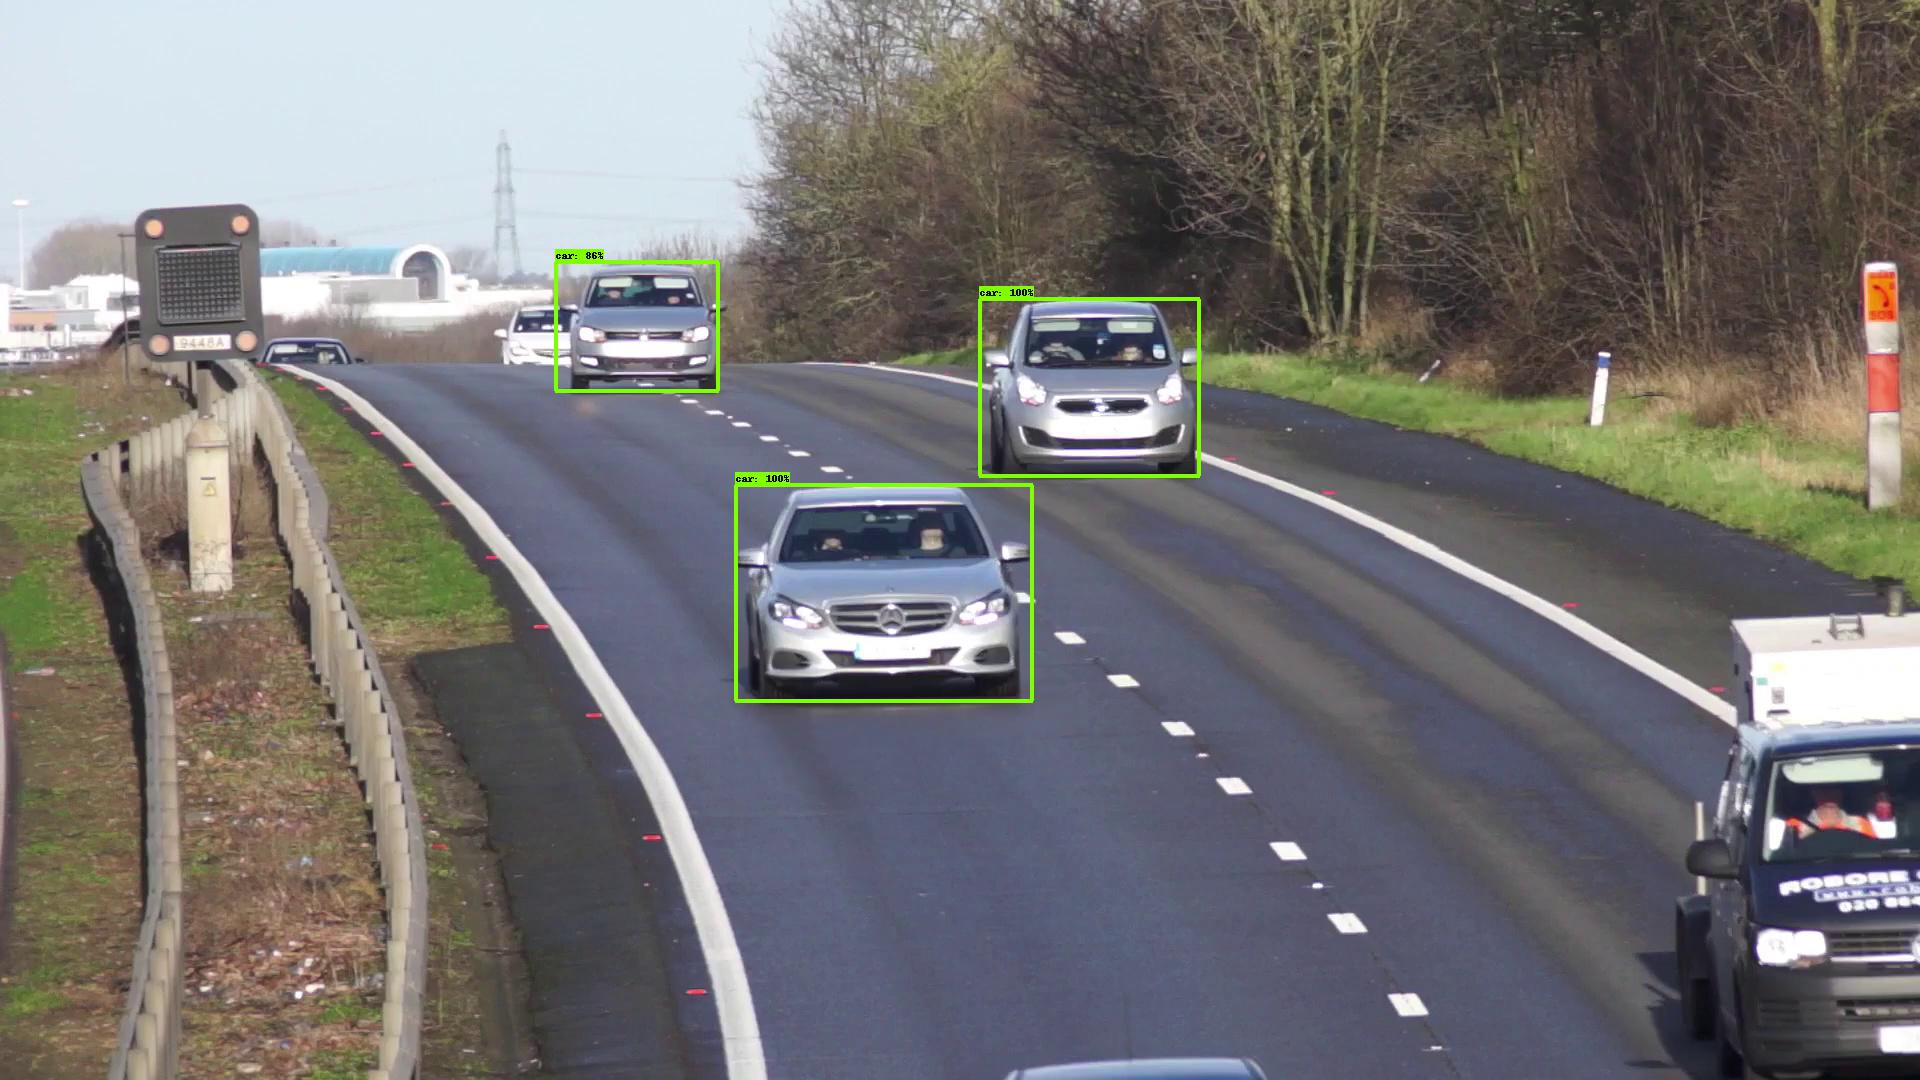


Frame 5


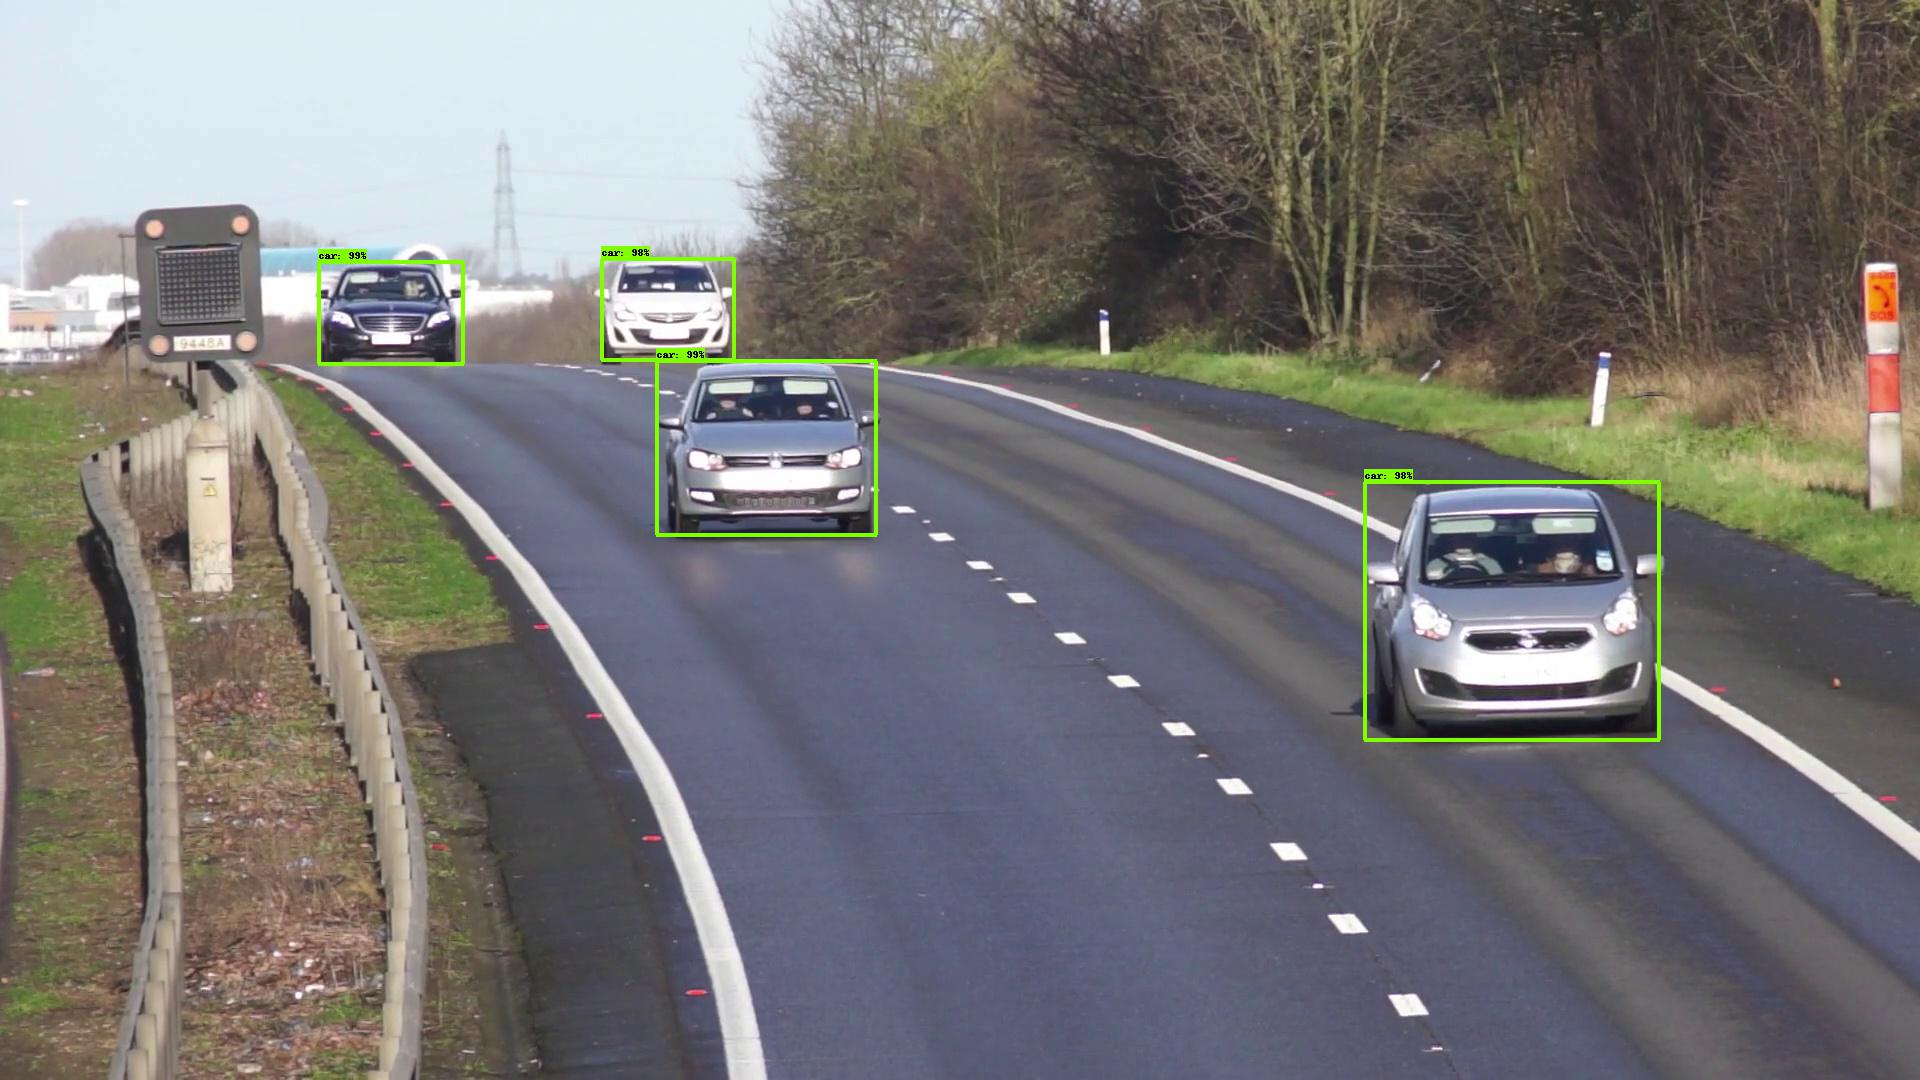


Frame 10


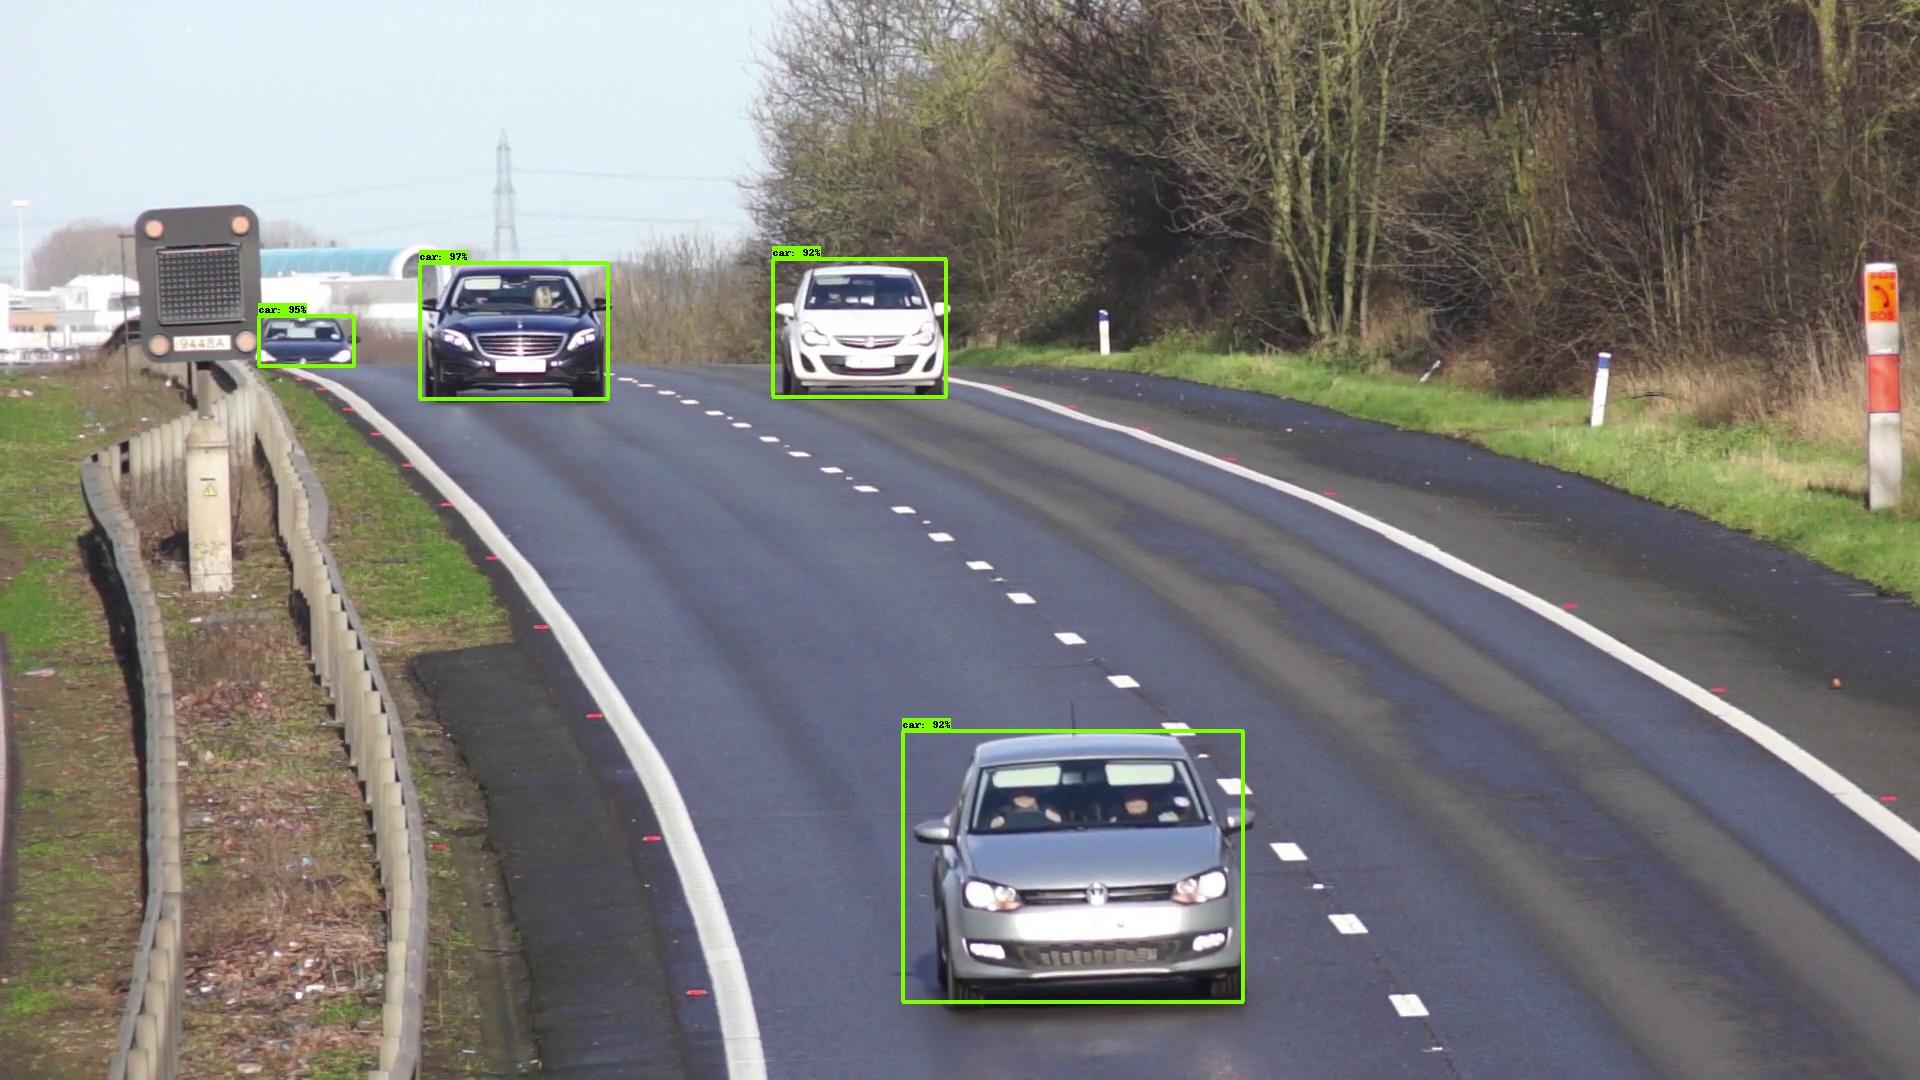

In [ ]:
print('Frame 0')
display(IPyImage('/content/results_2/gif_frame_00.jpg'))
print()
print('Frame 5')
display(IPyImage('/content/results_2/gif_frame_05.jpg'))
print()
print('Frame 10')
display(IPyImage('/content/results_2/gif_frame_10.jpg'))

In [51]:
%cd /content/
imageio.plugins.freeimage.download()

anim_file = './car-anim_2.gif'

filenames = glob.glob('/content/results_2/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

/content
